# Table of Contents
 <p><div class="lev1"><a href="#Import-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries</a></div><div class="lev1"><a href="#Data-opening-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data opening</a></div><div class="lev1"><a href="#Variable-and-period-of-analysis-selection-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Variable and period of analysis selection</a></div><div class="lev1"><a href="#Deseasonalizing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Deseasonalizing</a></div><div class="lev1"><a href="#Regressor-loading-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Regressor loading</a></div><div class="lev1"><a href="#Regression-function-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Regression function</a></div><div class="lev1"><a href="#Regression-calculation-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Regression calculation</a></div><div class="lev1"><a href="#Visualization-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Visualization</a></div>

# Import libraries

In [2]:
# import supp_functions as fce
import xarray as xr
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

/home/weiwu/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Data opening

In [3]:
s_year = 1979
e_year = 2009
vari ='t'

in_dir = '~/'
in_netcdf = in_dir + 'jra55_tmp_1960_2009_zm.nc'
ds = xr.open_dataset(in_netcdf)

FileNotFoundError: [Errno 2] No such file or directory: '/home/weiwu/jra55_tmp_1960_2009_zm.nc'

# Variable and period of analysis selection

In [4]:
times = pd.date_range(str(s_year)+'-01-01', str(e_year)+'-12-31', name='time', freq = 'M')
ds_sel = ds.sel(time = times, method='ffill') #nearest
ds_sel = ds_sel[vari]

# Deseasonalizing

In [5]:
climatology = ds_sel.groupby('time.month').mean('time')
anomalies = ds_sel.groupby('time.month') - climatology

# Regressor loading

In [24]:
global reg

solar = fce.open_reg_ccmi(in_dir+'solar_1947.nc', 'solar', 0, 1947, s_year, e_year)
solar /= 126.6

trend = np.linspace(-1, 1, solar.shape[0])

norm = 4
what_re = 'jra55'
what_sp = ''
i_year2 = 1947
i_year = 1960
what_re2 = 'HadISST'
saod = fce.open_reg_ccmi(in_dir+'sad_gm_50hPa_1949_2013.nc', 'sad', 0, 1949, s_year, e_year)
qbo1 = fce.open_reg_ccmi(in_dir+'qbo_'+what_re+what_sp+'_pc1.nc', 'index', norm, i_year, s_year, e_year)
qbo2 = fce.open_reg_ccmi(in_dir+'qbo_'+what_re+what_sp+'_pc2.nc', 'index', norm, i_year, s_year, e_year)                   
enso = fce.open_reg_ccmi(in_dir+'enso_'+what_re2+'_monthly_'+str(i_year2)+'_'+str(e_year)+'.nc', \
                     'enso', norm, i_year2, s_year, e_year)
print(trend.shape, solar.shape, saod.shape, enso.shape, qbo1.shape, qbo2.shape, anomalies.time.shape)
reg = np.column_stack((trend, solar, qbo1, qbo2, saod, enso)) 

((372L,), (372L,), (372L,), (372L,), (372L,), (372L,), (372,))


# Regression function

In [15]:
def xr_regression(y):
    X = sm.add_constant(reg, prepend=True) # regressor matrix
    mod = sm.GLSAR(y.values, X, 2, missing = 'drop') # MLR analysis with AR2 modeling
    res = mod.iterative_fit()

    return xr.DataArray(res.params[1:])

# Regression calculation

In [22]:
stacked = anomalies.stack(allpoints = ['lev', 'lat']).squeeze()
stacked = stacked.reset_coords(drop=True)
coefs = stacked.groupby('allpoints').apply(xr_regression)
coefs_unstacked = coefs.unstack('allpoints')

# Visualization

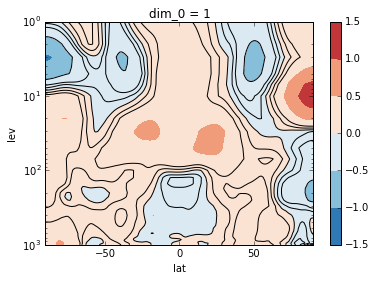

In [23]:
%matplotlib inline

coefs_unstacked.isel(dim_0 = [1]).squeeze().plot.contourf(yincrease=False)#, vmin=-1, vmax=1, cmap=plt.cm.RdBu_r)
coefs_unstacked.isel(dim_0 = [1]).squeeze().plot.contour(yincrease=False, colors='k', add_colorbar=False, \
                                                        levels = [-0.5, -0.2,-0.1,0,0.1,0.2, 0.5])
plt.yscale('log')